In [ ]:
'''
URJC / GIA / Aprendizaje Automático 1 / Curso 23-24
alfredo.cuesta@urjc.es
'''
from copy import deepcopy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, PolynomialFeatures
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report

plt.rcParams['figure.figsize']=(5,5)
np.set_printoptions(precision=2)
pd.set_option("display.precision", 4)
seed = 1460

En este curso hemos aprendido muchas técnicas y modelos de aprendizaje automático.

El código de la mayor parte de los cuadernos era imperativo y, alguna vez, orientado a objetos en el sentido de que hemos programado clases.

Evidentemente, a la hora de abordar un proyecto de ML, no podemos desarrollar el código en cuadernos. <br>
El _cliente_ no está interesado en el código para aprender el modelo o a lo mejor nosotros no se lo queremos dar porque ofrecemos MLaaS (_Machine Learning as a Service_).

Por otra parte, un proyecto de ML, como cualquier otro proyecto de informática, debe seguir unas directrices básicas para poder adaptarse a nuevas especificaciones sin tener que rehacer todo el código.

En este cuaderno se explican 3 elementos importantes a la hora de realizar un buen proyecto de ML:
- La utilización de **tuberías** (_pipelines_) para secuenciar o paralelizar etapas a la hora de entrenar una máquina.
- Sistematizar la validación de un modelo mediante **validación cruzada con _K-fold_** (_K-fold cross validation_)
- Automatizar la búsqueda de hiperparámetros con **búsqueda exhaustiva** (_grid search_)

# Pipelines

Para alimentar un modelo con datos de entrenamiento casi siempre hay que dedicar mucho tiempo a realizar varias tareas previas con los datos para obtener la tabla definitiva (la que utilizaremos para aprender los parámetros del modelo).

Como hemos aprendido (y hecho en las dos prácticas) una vez que se despliegue la máquina en destino y comiencen a llegar ejemplos nuevos, estos deben ser preprocesados igual que los datos en entrenamiento antes de pasar al modelo para realizar la inferencia.

Una solución (la de las prácticas) es almacenar cada objeto transformador. <br>
Así, el programa que entregamos al _cliente_ sólo tiene que cargar esos transformadores y ejecutarlos en el mismo orden con los nuevos ejemplos que lleguen.

> <small>De aquí en adelante llamaremos:
<br>**script-train** al código completo que escribimos para crear la máquina completa, incluido el entrenamiento del modelo elegido.
<br>**sript-test** al código completo que escribirmos para hacer inferencia con ejemplos nuevos.</small>

Esta manera de trabajar tiene varias desventajas:
- O bien utilizamos una variable diferente para cada salida de un paso, que es la entrada al siguiente, o bien utilizamos siempre la misma variable, que vamos reescribiendo en cada paso. <br>
Ambas son un problema. <br>
  --- La primera porque si la secuencia es muy larga acabaremos teniendo un código muy complicado de entender<br>
  --- La segunda porque es más complicado de depurar y puede provocar errores si se trabaja con punteros. Esto ocurrre en proyectos reales, donde normalmente se programa en C++
- Si añadimos, quitamos o cambiamos el orden de los transformadores, o cambiamos el modelo en el script-train, hay que hacer lo mismo en script-test. <br>
Esto también es un problema. Cuantos más etapas haya que replicar en el script-test más probabilidades hay de cometer errores.
- La máquina que se despliega en el lugar de trabajo consistirá en varios ficheros. En concreto, al menos: el script-test, un fichero por cada etapa del preprocesado y un fichero con el modelo.<br>
Cuantos más ficheros, más probabilidades de que surja algún problema.
- La máquina entregada es bastante "transparente". Cualquiera con acceso a los ficheros podría entender (al menos hasta cierto punto) lo que hace. <br>
Esto supone un problema porque hace las máquinas más vulnerables.
> <small>A un modelo de ML se le pueden poner "puertas trasearas" y se le puede engañar modificando ligeramente las entradas tanto si se tiene acceso al código (white box attack) como si no (black box attack)</small>

Si pudieramos introducir todas las etapas, incluyendo el modelo, en un único objeto entonces:
- ya no habría que utilizar variables intermedias para nombrar las salidas/entradas de las etapas
- El script-test se reduciría prácticamente a:
  1. cargar el objeto
  2. leer un nuevo ejemplo, o un lote de ejemplos
  3. ejecutar el objeto para producir las predicciones
- Sólo habría dos ficheros: el script-test y ese objeto
- El objeto es todo lo que se ve de la máquina final.<br>
En Python eso significa que se puede ver todo lo que hay dentro también, pero un proyecto real podría estar compilado y sería más dificil averiguar qué se hace dentro de él.

Este objeto se llama **tubería** o **pipeline**.

En la figura de abajo se muestra un ejemplo de cómo funcionaría.

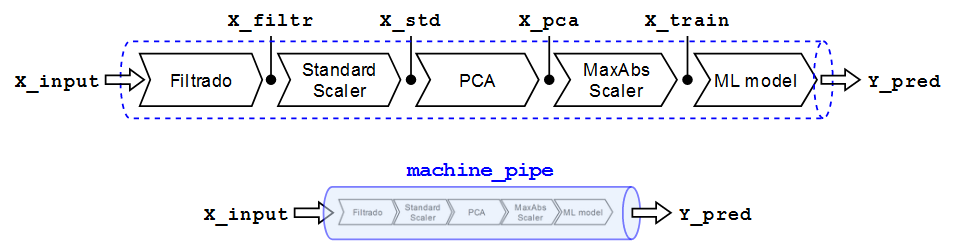

En Python las etapas de un pipeline pueden ser:
- secuenciales
- en paralelo

Las etapas **secuenciales** son la gran mayoria ya que el preprocesado de los datos es normalmente una secuencia de órdenes que modifican las características.

PERO hacer ingeniería de características y crear nuevas columnas en la tabla de datos, puede ser un proceso en paralelo salvo que una característica nueva tenga que ser creada despúes de otra.

Para secuencializar o paralelizar tareas tenemos las clases
- `sklearn.pipeline.Pipeline` &nbsp; para etapas secuenciales
- `sklearn.pipeline.FeatureUnion` &nbsp; para etapas paralelas, aunque no vamos a ver ningún ejemplo de código porque necesita programación orientada a objetos.

En ambos casos:
1. hay que pasarle las etapas en forma de lista de objetos
2. hay un método `fit` para aprender las transformaciones y un método `transform` para aplicarlas a los datos de entrada al pipeline.


## Ejemplo

Vamos a ver con un ejemplo como se aplica un pipeline completo.

In [ ]:
#- Cargar los datos

data = load_wine()

In [ ]:
#- procesar los datos para convertirlos en un problema de clasificación binaria
#  con un dataframe para los datos y otro para las etiquetas

target_label = 0 #<- {0, 1, 2}  El que se elija se convierte en 1 y los otros en 0.

dataSet = pd.DataFrame(data.data, columns = data.feature_names)
targetSet = pd.DataFrame(data.target, columns = ['target'])
targetSet = pd.DataFrame(targetSet['target']==target_label)*1


In [ ]:
#- Separar en entrenamiento y validación

train_X, test_X, train_Y, test_Y = train_test_split(dataSet, targetSet,
                                                    stratify = targetSet,
                                                    shuffle = True,
                                                    random_state = seed)

In [ ]:
#- etapas a utilizar en el pipeline (desordenadas a proposito)

model = LogisticRegression()

scaler = MaxAbsScaler().set_output(transform="pandas")

std_scaler = StandardScaler().set_output(transform="pandas")

poly_degree = 2
polyfeat = PolynomialFeatures(poly_degree).set_output(transform="pandas")

n_components = .8
pca = PCA(n_components).set_output(transform="pandas")

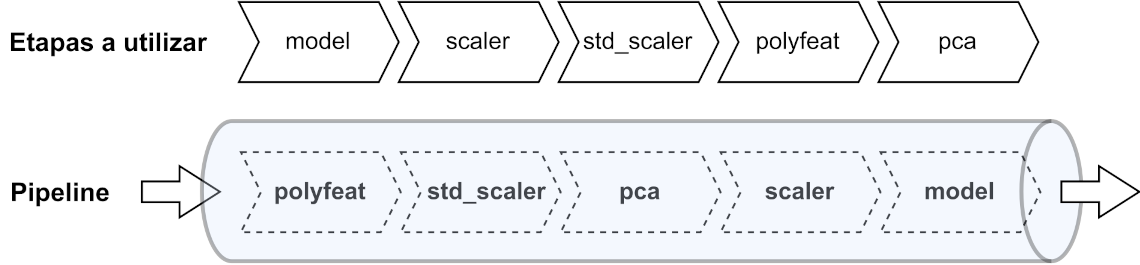

In [ ]:
#- Crear el pipeline:

#  Un pipeline es una lista de tuplas (nombre de la etapa, objeto)

pipe_list = []

pipe_list.append(('polyfeat', polyfeat))
pipe_list.append(('std_scaler', std_scaler))
pipe_list.append(('pca', pca))
pipe_list.append(('scaler', scaler))
pipe_list.append(('model', model))

#  Creamos el objeto pipeline que empaqueta todas las etapas de la lista.

machine_pipe = Pipeline(pipe_list)

#- Mostrar el pipeline:

machine_pipe

Pipeline(steps=[('polyfeat', PolynomialFeatures()),
                ('std_scaler', StandardScaler()),
                ('pca', PCA(n_components=0.8)), ('scaler', MaxAbsScaler()),
                ('model', LogisticRegression())])

In [ ]:
machine_pipe.fit(train_X, train_Y['target'])
Y_pred = machine_pipe.predict(test_X)
print("confusion matrix:")
confusion_matrix(test_Y, Y_pred)

confusion matrix:


array([[28,  2],
       [ 1, 14]])

# Validación cruzada con _K-fold_

Como hemos repetido desde el primer cuaderno, lo primero que se debe hacer cuando recibimos el conjunto de datos es separarlo en Entrenamiento y Test. <br>
Después de guardar el conjunto de Test, volvemos a separar el de Entrenamiento en dos: Entrenamiento y Validación.
> * Obviamente también se puede hacer la separación en tres subconjuntos desde el principio. <br> Se explica así porque el método `train_test_split` sólo separa en dos.<br>
* Si tenemos un conjunto de Test (como ocurre en las prácticas), entocnes la separación es directamente en Entrenamiento y Validación.  

Si hacemos esto 1 vez obtendremos 1 máquina $~\rightarrow~$
**¿Por qué no lo hacemos varias veces?**

Si tenemos varias máquinas podemos:
- valorar la robustez de sus resultados
- analizar la distribución de los parámetros

En definitiva, crear una máquina mejor.

PERO **¡ sólo tenemos 1 conjunto de datos !**

La técnica K-fold ("K-pliegues") entrena $K$ modelos con conjuntos de entrenamiento similares pero no completamente iguales, y cada uno es validado con un conjunto de validación diferente.

Para ello, en vez tomar un porcentaje del conjunto de entrenamiento para validación, se divide el conjunto de entrenamiento en $K$ partes iguales (o tan iguales como se pueda) y se toman $K-1$ para entrenamiento y la restante para validación.
<br>
Con esta división se entrena un primer modelo.

A continuación se repite el proceso pero dejando fuera una de las partes diferente a la anterior.

Así, es posible entrenar $K$ modelos diferentes y validar cada uno de ellos con un conjunto de datos diferente.

La figura de abajo representa este proceso.

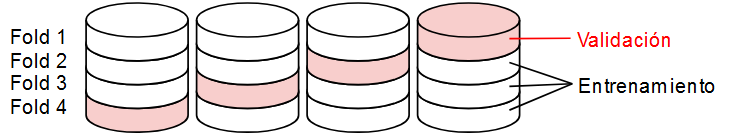

Hay varias maneras de realizar validación cruzada. <br>

La más genérica es aquella que sólo divide el conjunto de datos de entrenamiento de esta manera. <br>
A partir de ahí ya se pueden realizar una serie de etapas (por ejemplo con un pipeline) para aprender la máquina.

En mi opinón lo más recomendable es utilizar la clase `model_selection.StratifiedKFold` de Scikit-Learn porque nos asegura una separación estratificada; es decir con el mismo porcentaje de ejemplos de cada clase tanto en los conjuntos de entrenamiento como los de validación.

In [ ]:
#- Crear los pliegues (folds)
n_splits = 4
skf = StratifiedKFold(n_splits = n_splits,
                      shuffle = True, random_state = seed)
skf.get_n_splits(train_X, train_Y)

#- Mostrar los índices de los ejemplos asignados a cada pliegue
for i, (train_index, valid_index) in enumerate(skf.split(train_X, train_Y)):
    print(f"Fold {i}: ----------------------------------------------------")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={valid_index}")

Fold 0: ----------------------------------------------------
  Train: index=[  0   2   6   7   8   9  11  12  14  17  18  19  21  22  23  24  25  27
  28  29  30  31  33  35  37  38  40  41  42  44  45  46  47  49  50  52
  53  54  56  57  58  60  61  62  63  64  65  66  68  70  71  72  73  74
  75  77  78  80  81  82  84  85  87  88  89  90  91  92  94  95  97  98
  99 100 102 103 105 107 108 109 110 111 112 113 115 116 118 121 122 123
 124 125 126 127 128 129 130 131 132]
  Test:  index=[  1   3   4   5  10  13  15  16  20  26  32  34  36  39  43  48  51  55
  59  67  69  76  79  83  86  93  96 101 104 106 114 117 119 120]
Fold 1: ----------------------------------------------------
  Train: index=[  0   1   2   3   4   5   7   8   9  10  12  13  14  15  16  18  19  20
  23  24  25  26  28  30  31  32  33  34  35  36  37  38  39  40  41  43
  44  45  46  48  50  51  53  54  55  57  58  59  60  62  63  64  65  67
  68  69  71  72  73  76  77  78  79  80  82  83  84  85  86  87  90  92

In [ ]:
#- Utilizar los pliegues para entrenar una máquina en forma de pipeline

pipe_list = []
for i, (train_index, valid_index) in enumerate(skf.split(train_X, train_Y)):
    print(f"Fold {i}: ---------")
    machine_pipe.fit(train_X.iloc[train_index], train_Y.iloc[train_index]['target'])
    Y_pred = machine_pipe.predict(train_X.iloc[valid_index])
    print("confusion matrix:")
    print( confusion_matrix(train_Y.iloc[valid_index], Y_pred) )
    pipe_list.append(deepcopy(machine_pipe)) #<- guardamos todos los pipes probados

Fold 0: ---------
confusion matrix:
[[23  0]
 [ 1 10]]
Fold 1: ---------
confusion matrix:
[[21  1]
 [ 0 11]]
Fold 2: ---------
confusion matrix:
[[21  1]
 [ 1 10]]
Fold 3: ---------
confusion matrix:
[[22  0]
 [ 1 10]]


**¿Con cuál de los 4 modelos nos quedamos?**
- ¿el que produce el mejor resultado?
- ¿el que produce el peor resultado?

Ni uno ni otro. Ambos casos son extremos.

Lo recomendable es quedarse con el modelo que produce el resultado más próximo al promedio de los resultados.

# Búsqueda de hiperparámetros con _grid search_

Casi todos los modelos que hemos estudiado tienen algún hiperparámetro.
<br>
Incluso si no es así, como ocurre con la regresión logística, el descenso del gradiente sí que lo tiene (el _learning rate_ $~\eta$).

Ajustar bien los hiperparámetros puede suponer la diferencia entre lograr un buen modelo o no.

La manera intuitiva es simplemente ejecutar el script-train una y otra vez variando los hiperparámetros y anotando los resultados según una o varias métricas de rendimiento. <br>
Finalmente nos quedaríamos con aquellos hiperparámetros que mejor rendimiento dan (obviamente en el conjunto de validación, no de entrenamiento).

La búsqueda exhaustiva o en _grid_ simplemente es hacer esto pero de manera sistemática.

El _grid_ se forma con cada una de las posibles combinaciones de los hiperparámetros que queremos explorar.

Por ejemplo, en la figura de abajo se representan 2 hiperparámetros de SVM para clasificación (SVC) con un kernel RBF; en concreto el valor de $C$ y la $\gamma$ (gamma) del kernel.<br>
El grid se representa como la rejilla de líneas discontinuas.<br>
Cada cruce es un par de hiperparámetros que da lugar a un modelo diferente.

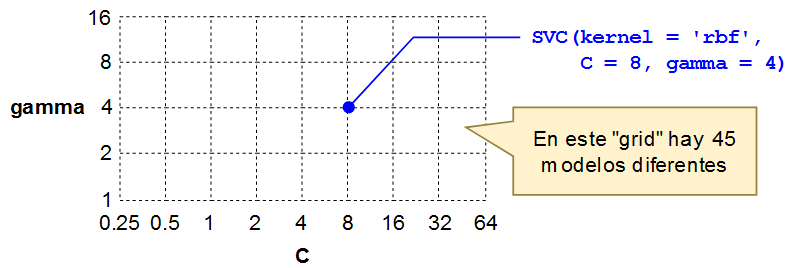

En la figura de arriba se prueban valores que crecen en potencias de 2.

Esto no es obligatorio. Se pueden hacer crecer en potencias de 10, o se puede hacer equiespaciado.

Personalmente yo creomiendo hacer una primera búsqueda creciendo en potencias de 2 y luego hacer una segunda y tecera búsqueda afinando con hiperparámetros equiespaciados.



In [ ]:
parameters = {'kernel':['rbf'],
              'gamma':[1, 2, 4, 8, 16],
              'C':[0.25, 0.5, 1, 2, 4, 8, 16, 32, 64]}
svc = SVC()

verbose = 3

grid_clf = GridSearchCV(svc, parameters, verbose = verbose, scoring='accuracy')
grid_clf.fit(train_X, train_Y['target'])
# print best parameter after tuning
print(grid_clf.best_params_)
grid_predictions = grid_clf.predict(test_X)

# print classification report
print(classification_report(test_Y['target'], grid_predictions))

Fitting 5 folds for each of 45 candidates, totalling 225 fits
[CV 1/5] END .......C=0.25, gamma=1, kernel=rbf;, score=0.667 total time=   0.0s
[CV 2/5] END .......C=0.25, gamma=1, kernel=rbf;, score=0.667 total time=   0.0s
[CV 3/5] END .......C=0.25, gamma=1, kernel=rbf;, score=0.667 total time=   0.0s
[CV 4/5] END .......C=0.25, gamma=1, kernel=rbf;, score=0.692 total time=   0.0s
[CV 5/5] END .......C=0.25, gamma=1, kernel=rbf;, score=0.654 total time=   0.1s
[CV 1/5] END .......C=0.25, gamma=2, kernel=rbf;, score=0.667 total time=   0.1s
[CV 2/5] END .......C=0.25, gamma=2, kernel=rbf;, score=0.667 total time=   0.0s
[CV 3/5] END .......C=0.25, gamma=2, kernel=rbf;, score=0.667 total time=   0.0s
[CV 4/5] END .......C=0.25, gamma=2, kernel=rbf;, score=0.692 total time=   0.0s
[CV 5/5] END .......C=0.25, gamma=2, kernel=rbf;, score=0.654 total time=   0.0s
[CV 1/5] END .......C=0.25, gamma=4, kernel=rbf;, score=0.667 total time=   0.0s
[CV 2/5] END .......C=0.25, gamma=4, kernel=rbf

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**¿Por qué aparecen esos Warnings al final?**

La máquina encontrada no produce alguna de las dos etiquetas posibles.

In [ ]:
print(grid_predictions)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0]


Efectivamente, nuestra máquina predice 0 para todos los ejemplos de test.

Nuestra máquina no es muy buena, seguramente porque NO hemos hecho ningún tipo de preprocesado. <br>
Hemos usado `train_X` tal cual lo hemos descargado para entrenar todos los SVM, mientras que en los ejemplos anteriores utilizabamos el pipeline.



**¿Se podría sustituir `svc` por `machine_pipe`?**

Sí, pero no es algo inmediato porque los parámetros que estamos buscando son de SVM, mientras que ese pipeline que hemos creado en los ejemplos anteriores utiliza regresión logística como modelo.

Un modo sencillo de hacer grid search utilizando pipelines es separar el modelo del resto de etapas del preprocesado.

# Ejercicios

Aprende más sobre estas técnicas y otras muy parecidas leyendo la documentación.

Puedes leer más sobre todas ellas en [sklearn.model_selection](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection).

Prueba a realizar estas técnicas en ejercicios anteriores